# Imports

In [1]:
import pandas as pd
import sklearn.metrics as metrics
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, date, timedelta
import talos
import math
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import requests
import io
from time import sleep
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, TimeDistributed, LSTM, Lambda
from tensorflow.keras import regularizers
import tensorflow as tf

Using TensorFlow backend.


# Load data
load hospitalisations and trends for Belgium and France

In [2]:
# topics considered
list_topics = {
    #'Fièvre': '/m/0cjf0',
    #'Mal de gorge': '/m/0b76bty',
    #'Dyspnée': '/m/01cdt5',
    #'Agueusie': '/m/05sfr2',
    #'Anosmie': '/m/0m7pl',
    #'Coronavirus': '/m/01cpyy',
    #'Virus': '/m/0g9pc',
    #'Température corporelle humaine': '/g/1213j0cz',
    #'Épidémie': '/m/0hn9s',
    #'Symptôme': '/m/01b_06',
    #'Thermomètre': '/m/07mf1',
    #'Grippe espagnole': '/m/01c751',
    #'Paracétamol': '/m/0lbt3',
    #'Respiration': '/m/02gy9_',
    #'Toux': '/m/01b_21'
}

# hospitalisations features given as input
list_hosp_features = [
    #'NEW_HOSP',
    'TOT_HOSP',
    #'TOT_HOSP_log',
    #'TOT_HOSP_pct',
]

geocodes = {
    'BE': "Belgique",
    #'FR-A': "Alsace-Champagne-Ardenne-Lorraine",
    #'FR-B': "Aquitaine-Limousin-Poitou-Charentes",
    #'FR-C': "Auvergne-Rhône-Alpes",
    #'FR-J': 'Ile-de-France'
}

Additional information: what is the target, should some features remain unscaled?

In [3]:
# target, should be one of the hosp features
target = 'TOT_HOSP'

# features that should not be scaled
unscaled = [
    #'NEW_HOSP',
    #'TOT_HOSP',
    #'TOT_HOSP_log',
    #'TOT_HOSP_pct',
    #'Fièvre',
    #'Mal de gorge',
    #'Dyspnée',
    #'Agueusie',
    #'Anosmie',
    #'Coronavirus',
    #'Virus',
    #'Température corporelle humaine',
    #'Épidémie',
    #'Symptôme',
    #'Thermomètre',
    #'Grippe espagnole',
    #'Paracétamol',
    #'Respiration',
    #'Toux',
]

In [4]:
date_begin = "2020-02-01"

def log_values(df, columns: list = None, base: int = 10, inf_value='drop'):
    """
    add log values to the dataframe
    :param df: dataframe to change
    :param columns: list of name of the columns that needs to be modified. None= all columns
    :param base: base for the logarithm. Supported: [10]. If not in the list, use logarithm in base e
    :param inf_value: value to give for the inf created by the log. Can be integer or 'drop' (dropping the values)
    :return dataframe with log values for the corresponding columns
    """
    if columns==None:
        columns = df.columns
    new_columns = [f"{name}_log" for name in columns]
        
    if base==10:
        df[new_columns] = np.log10(df[columns])
    else:
        df[new_columns] = np.log(df[columns]) / np.log(base)
        
    if inf_value == 'drop':
        df = df.replace([np.inf, -np.inf], np.nan).dropna()
    else: #inf_value should be an integer
        df = df.replace([np.inf, -np.inf], inf_value)
    return df
        

def pct_values(df, columns: list = None, add_one: bool = False):
    """
    add percentage values to the dataframe
    :param df: dataframe to change
    :param columns: list of name of the columns that needs to be modified. None= all columns
    :param add_one: if True, the percentage of difference add a value of 100% to each percentage
    :return dataframe with pct change values for the corresponding columns
    """
    if columns==None:
        columns = df.columns
    new_columns = [f"{name}_pct" for name in columns]
    df[new_columns] = df[columns].pct_change()
    if add_one:
        df[new_columns] = df[new_columns] + 1
    return df
    

def create_dataframe_hospi(hospi_france_tot, hospi_france_new, hospi_belgium, department_france, geo, 
                           new_hosp_in=True, tot_hosp=True):
    """
    Creates the dataframe containing the number of daily new hospitalizations
    with respect to the date and the localisation (FR and BE)
    :param hospi_france_tot: url/path for the total french hospitalisations csv
    :param hospi_france_new: url/path for the new french hospitalisations csv
    :param hospi_belgium: url/path for the belgian hospitalisations csv
    :param department_france: url/path for the mapping of french department to regions
    :param geo: geocode of the region that should be incuded in the final dict
    :param new_hosp_in: if True, includes the new daily hospitalisations (inwards)
    :param tot_hosp: if True, includes the total hospitalisations
    :return dict of {geocode: hosp_df} where hosp is hospitalisation dataframe of each geocode
    """
    columns_be = {}  # only for belgium, not for france (the files are handled differently)
    data_columns = []  # final data columns that will be present in the df
    if new_hosp_in:
        columns_be['NEW_IN'] = 'sum'
        data_columns.append("NEW_HOSP")
    if tot_hosp:
        columns_be['TOTAL_IN'] = 'sum'
        data_columns.append("TOT_HOSP")
    if len(columns_be) == 0:
        raise Exception("no hospitalisation column specified")
    date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")
    departements = pd.read_csv(department_france)
    
    # French data: total hospitalisation
    if tot_hosp:
        hospitalisations = pd.read_csv(hospi_france_tot, sep=";", parse_dates=['jour'], date_parser=date_parser)
        hospitalisations = hospitalisations[hospitalisations['sexe'] == 0]  # sex=0: men and women
        data_fr_tot = hospitalisations.join(departements.set_index('departmentCode'), on="dep").groupby(
            ["regionTrends", "jour"], as_index=False).agg({"hosp": "sum"})
    
    # French data: new hospitalisation
    if new_hosp_in:
        hospitalisations = pd.read_csv(hospi_france_new, sep=";", parse_dates=['jour'], date_parser=date_parser)
        data_fr_new = hospitalisations.join(departements.set_index('departmentCode'), on="dep").groupby(
            ["regionTrends", "jour"],as_index=False).agg({"incid_hosp": "sum"})
    
    # merge the french data
    common_columns = ["regionTrends", "jour"]
    if tot_hosp and new_hosp_in:
        data_fr = data_fr_tot.merge(data_fr_new, how='outer',left_on=common_columns, right_on=common_columns).fillna(0)
    elif tot_hosp:
        data_fr = data_fr_tot
    elif new_hosp_in:
        data_fr = data_fr_new
    data_fr = data_fr.rename(columns={"jour": "DATE", "regionTrends": "LOC", "hosp": "TOT_HOSP", "incid_hosp": "NEW_HOSP"})
    
    # Belgian data
    data_be = pd.read_csv(hospi_belgium, parse_dates=['DATE'], date_parser=date_parser).groupby(
        ["DATE"], as_index=False).agg(columns_be).rename(
        columns={"TOTAL_IN": "TOT_HOSP", "NEW_IN": "NEW_HOSP"})
    data_be["LOC"] = "BE"
    
    # Full data
    full_data = data_fr.append(data_be).set_index(["LOC", "DATE"])
    
    # find smallest date for each loc and highest common date
    smallest = {}
    highest = {}
    for loc, date_current in full_data.index:
        if loc not in smallest or smallest[loc] > date_current:
            smallest[loc] = date_current
        if loc not in highest or highest[loc] < date_current:
            highest[loc] = date_current
        
    highest_date = min(highest.values())
    base_date = datetime.strptime(date_begin, "%Y-%m-%d").date()

    # Add "fake" data (zeroes before the beginning of the crisis) for each loc
    toadd = []
    add_entry = [0 for i in range(len(data_columns))]  # each missing entry consist of zero for each data col
    for loc, sm in smallest.items():
        end = sm.date()
        cur = base_date

        while cur != end:
            toadd.append([cur, loc, *add_entry])
            cur += timedelta(days=1)
            
    full_data = pd.DataFrame(toadd, columns=["DATE", "LOC", *data_columns]).append(full_data.reset_index()).set_index(
        ["LOC", "DATE"])
    data_dic = {}
    
    for k, v in geo.items():
        data_dic[k] = full_data.iloc[(full_data.index.get_level_values('LOC') == k) & 
                                     (full_data.index.get_level_values('DATE') <= highest_date)]
    return data_dic


def create_df_trends(url_trends, geo):
    """
    return dic of {geo: df} for the trends
    """
    date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")
    renaming = {v: k for k, v in list_topics.items()}  # change topic_mid to topic_title in the dataframe
    if len(renaming)==0:
        return {k: pd.DataFrame() for k in geocodes}
    result = {}
    for k, v in geo.items():
        all_trends = []
        for term in list_topics.keys():
            path = f"{url_trends}{k}-{term}.csv"
            encoded_path = requests.get(path).content
            df_trends = pd.read_csv(io.StringIO(encoded_path.decode("utf-8")),
                                    parse_dates=['date'], date_parser=date_parser
                                   ).rename(columns={"date": "DATE"})
            df_trends['LOC'] = k
            df_trends.rename(columns=renaming, inplace=True)
            df_trends.set_index(['LOC', 'DATE'], inplace=True)
            all_trends.append(df_trends)
        result[k] = pd.concat(all_trends, axis=1)
    return result

In [5]:
url_trends = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/data/trends/model/"
url_hospi_belgium = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/data/hospi/be-covid-hospi.csv"
url_department_france = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/src/france_departements.csv"
url_hospi_france_new = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/data/hospi/fr-covid-hospi.csv"
url_hospi_france_tot = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/data/hospi/fr-covid-hospi-total.csv"

# Percentage is True if we want to take the difference of variation between today and yesterday in percentage
# Total is True if we want to add the absolute total value to the input of the model
df_trends = create_df_trends(url_trends, geocodes)
df_hospi = create_dataframe_hospi(url_hospi_france_tot, url_hospi_france_new, url_hospi_belgium, 
                                  url_department_france, geocodes)
for k in geocodes.keys():
    # Rolling average of 7 days 
    df_hospi[k] = df_hospi[k].rolling(7, center=True).mean().dropna()
    df_trends[k] = df_trends[k].rolling(7, center=True).mean().dropna()
    df_hospi[k] = log_values(df_hospi[k], columns=['TOT_HOSP'])
    df_hospi[k] = pct_values(df_hospi[k], columns=['TOT_HOSP'])
    df_hospi[k] = df_hospi[k][list_hosp_features]
    
    """
    print(f"--------------------{k}-----------------------")
    plt.figure()
    plt.plot(df_hospi[k]['HOSP'].reset_index().drop(columns=["LOC"]).set_index('DATE'), label='Diff hospi')
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(df_hospi[k]['TOT_HOSP'].reset_index().drop(columns=["LOC"]).set_index('DATE'), label='Total hospi')
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(df_trends[k]['Fièvre'].reset_index().drop(columns=["LOC"]).set_index('DATE'), label='Fièvre')
    plt.plot(df_trends[k]['Mal de gorge'].reset_index().drop(columns=["LOC"]).set_index('DATE'), label='Mal de gorge')
    plt.plot(df_trends[k]['Agueusie'].reset_index().drop(columns=["LOC"]).set_index('DATE'), label='Agueusie')
    plt.legend()
    plt.show()
    """

# Preprocess data

## Normalization [0,1]

In [6]:
df_hospi['BE']

TOT_HOSP
LOC DATE                   
BE  2020-03-12    38.000000
    2020-03-13    90.857143
    2020-03-14   161.857143
    2020-03-15   254.714286
    2020-03-16   375.285714
...                     ...
    2020-12-21  2537.428571
    2020-12-22  2490.000000
    2020-12-23  2456.571429
    2020-12-24  2431.285714
    2020-12-25  2407.000000

[289 rows x 1 columns]

In [7]:
inverse_param = {}
scaler = MinMaxScaler(feature_range=(0, 1))
for k in geocodes.keys():
    if len(list_topics) !=0:
        to_scale = [name for name in df_trends[k].columns if name not in unscaled]
        df_trends[k] = pd.DataFrame(scaler.fit_transform(df_trends[k].values), columns=to_scale, index=df_trends[k].index)
    # store a tuple of min,max
    inverse_param[k] = (df_hospi[k][target].min(), df_hospi[k][target].max())
    to_scale = [name for name in df_hospi[k].columns if name not in unscaled]
    df_hospi[k][to_scale] = pd.DataFrame(scaler.fit_transform(df_hospi[k][to_scale].values), columns=to_scale, index=df_hospi[k].index)
# store the inverse transform for the target only
inverse_transform = lambda df,k: df[[target]] * (inverse_param[k][1] - inverse_param[k][0]) + inverse_param[k][0] 
df_hospi['BE']

TOT_HOSP
LOC DATE                
BE  2020-03-12  0.000000
    2020-03-13  0.007366
    2020-03-14  0.017260
    2020-03-15  0.030200
    2020-03-16  0.047003
...                  ...
    2020-12-21  0.348311
    2020-12-22  0.341701
    2020-12-23  0.337043
    2020-12-24  0.333519
    2020-12-25  0.330135

[289 rows x 1 columns]

In [8]:
inverse_transform(df_hospi['BE'], 'BE')

TOT_HOSP
LOC DATE                   
BE  2020-03-12    38.000000
    2020-03-13    90.857143
    2020-03-14   161.857143
    2020-03-15   254.714286
    2020-03-16   375.285714
...                     ...
    2020-12-21  2537.428571
    2020-12-22  2490.000000
    2020-12-23  2456.571429
    2020-12-24  2431.285714
    2020-12-25  2407.000000

[289 rows x 1 columns]

## Days used for the forecast
Each forecast is done for `n_forecast` days and uses `n_samples` days before to construct the prediction

In [9]:
n_forecast = 1  # Number of days we want to predict
n_samples = 14  # Number of days used to make the prediction
shift_hospi = 1  # delay between a date and its newest hosp value for this date 
# (ex: 26/10's newest value is for 25/10)
shift_trends = 1  # delay between a date and its newest trends value for this date

## Add lag

In [10]:
def timeseries_shift(data, lag, dropna=True):
    """
    Changes all columns with their shifted data
    """
    return data.shift(lag).dropna()

for k in geocodes.keys():
    df_hospi[k] = timeseries_shift(df_hospi[k], shift_hospi)
    df_trends[k] = timeseries_shift(df_trends[k], shift_trends)

In [11]:
def timeseries_add_lag(data, lag, dropna=True):
    #Adds lagged values to dataframe
    df = pd.DataFrame(data)
    init_columns = df.columns
    columns = [df.shift(i) for i in range(lag-1, 0, -1)]
    renaming = {}  # rename the columns
    delay = lag-1
    for i in range(lag-1):
        for k in init_columns:
            renaming[k] = f'{k}(t-{delay})'
        columns[i].rename(columns=renaming ,inplace=True)
        delay -= 1
    columns.append(df)
    df = pd.concat(columns, axis=1)
    return df.dropna() if dropna else df


if len(list_topics) !=0:
    merged_df = {k: pd.merge(df_hospi[k], df_trends[k], left_index=True, right_index=True).dropna() for k,v in geocodes.items()}
else:
    merged_df = {k: df_hospi[k] for k in geocodes}
    
# use the same date interval in all dataframes
min_date = datetime.strptime("1990-12-01", "%Y-%m-%d").date()
max_date = datetime.strptime("2050-12-01", "%Y-%m-%d").date()
for k in merged_df:
    index_date = merged_df[k].index.get_level_values(1)
    min_date = max(min_date, index_date.min())
    max_date = min(max_date, index_date.max())
for k in merged_df:
    merged_df[k] = merged_df[k].loc[pd.IndexSlice[:,min_date:max_date,:]]    

n_features = len(merged_df['BE'].columns)
lagged_df = {}
for k in geocodes.keys():
    lagged_df[k] = timeseries_add_lag(merged_df[k], n_samples)

In [12]:
merged_df['BE']

TOT_HOSP
LOC DATE                
BE  2020-03-13  0.000000
    2020-03-14  0.007366
    2020-03-15  0.017260
    2020-03-16  0.030200
    2020-03-17  0.047003
...                  ...
    2020-12-21  0.353009
    2020-12-22  0.348311
    2020-12-23  0.341701
    2020-12-24  0.337043
    2020-12-25  0.333519

[288 rows x 1 columns]

In [13]:
lagged_df['BE']

TOT_HOSP(t-13)  TOT_HOSP(t-12)  TOT_HOSP(t-11)  \
LOC DATE                                                         
BE  2020-03-26        0.000000        0.007366        0.017260   
    2020-03-27        0.007366        0.017260        0.030200   
    2020-03-28        0.017260        0.030200        0.047003   
    2020-03-29        0.030200        0.047003        0.068922   
    2020-03-30        0.047003        0.068922        0.096474   
...                        ...             ...             ...   
    2020-12-21        0.435150        0.426151        0.418327   
    2020-12-22        0.426151        0.418327        0.411379   
    2020-12-23        0.418327        0.411379        0.403735   
    2020-12-24        0.411379        0.403735        0.396488   
    2020-12-25        0.403735        0.396488        0.389978   

                TOT_HOSP(t-10)  TOT_HOSP(t-9)  TOT_HOSP(t-8)  TOT_HOSP(t-7)  \
LOC DATE                                                                      
BE  2020-03-26        0.030200       0.047003       0.068922       0.096474   
    2020-03-27        0.047003       0.068922       0.096474       0.123947   
    2020-03-28        0.068922       0.096474       0.123947       0.154068   
    2020-03-29        0.096474       0.123947       0.154068       0.186777   
    2020-03-30        0.123947       0.154068       0.186777       0.228007   
...                        ...            ...            ...            ...   
    2020-12-21        0.411379       0.403735       0.396488       0.389978   
    2020-12-22        0.403735       0.396488       0.389978       0.384444   
    2020-12-23        0.396488       0.389978       0.384444       0.378870   
    2020-12-24        0.389978       0.384444       0.378870       0.373952   
    2020-12-25        0.384444       0.378870       0.373952       0.367522   

                TOT_HOSP(t-6)  TOT_HOSP(t-5)  TOT_HOSP(t-4)  TOT_HOSP(t-3)  \
LOC DATE                                                                     
BE  2020-03-26       0.123947       0.154068       0.186777       0.228007   
    2020-03-27       0.154068       0.186777       0.228007       0.272461   
    2020-03-28       0.186777       0.228007       0.272461       0.323207   
    2020-03-29       0.228007       0.272461       0.323207       0.377058   
    2020-03-30       0.272461       0.323207       0.377058       0.433477   
...                       ...            ...            ...            ...   
    2020-12-21       0.384444       0.378870       0.373952       0.367522   
    2020-12-22       0.378870       0.373952       0.367522       0.361988   
    2020-12-23       0.373952       0.367522       0.361988       0.357707   
    2020-12-24       0.367522       0.361988       0.357707       0.353009   
    2020-12-25       0.361988       0.357707       0.353009       0.348311   

                TOT_HOSP(t-2)  TOT_HOSP(t-1)  TOT_HOSP  
LOC DATE                                                
BE  2020-03-26       0.272461       0.323207  0.377058  
    2020-03-27       0.323207       0.377058  0.433477  
    2020-03-28       0.377058       0.433477  0.493480  
    2020-03-29       0.433477       0.493480  0.550198  
    2020-03-30       0.493480       0.550198  0.599948  
...                       ...            ...       ...  
    2020-12-21       0.361988       0.357707  0.353009  
    2020-12-22       0.357707       0.353009  0.348311  
    2020-12-23       0.353009       0.348311  0.341701  
    2020-12-24       0.348311       0.341701  0.337043  
    2020-12-25       0.341701       0.337043  0.333519  

[275 rows x 14 columns]

## Reshape
The data is reshaped in order to obtain the right format for LSTM:

`[nb_samples, timesteps, input_dim]`

In [14]:
# shape format for LSTM: [nb_samples, timesteps, input_dim]
dataset = {}
for k in geocodes.keys():
    dataset[k] = lagged_df[k].values.reshape(lagged_df[k].shape[0], n_samples, n_features)
dataset['BE'].shape

(275, 14, 1)

We want the targets to be always differents. For instance, if we use 2 days of forecast based on 3 days of data and the days are indexed as integers we want to have:
1. `x: [1,2,3]`, `y: [4,5]`
2. `x: [3,4,5]`, `y: [6,7]`
2. `x: [5,6,7]`, `y: [8,9]`

and so on. **But** this is only done for the fitting of the data. For the prediction itself, we will do it with one days of steps. In the end, if we use days 1 to 7 for the fit and want to predict afterwards, it will look like:

- **fit**: 
    1. `x: [1,2,3]`, `y: [4,5]`
    2. `x: [3,4,5]`, `y: [6,7]`
- **prediction**
    1. `x: [5,6,7]`, `y: [8,9]`
    2. `x: [6,7,8]`, `y: [9,10]`
    
    and so on
    
The prediction presents overlaps in order to obtain a real-time tool, that can be actualized every day

In [15]:
target_idx = lagged_df['BE'].columns.to_list().index(target)
target_idx = target_idx % ((n_samples-1) * n_features)
target_idx

0

In [16]:
# we take all possible dates for y. If not all dates can be taken, the first dates are dropped
first_set = (len(dataset) - 1) % n_forecast
all_x_set = {}
all_y_set = {}
for k in geocodes:
    all_y_set[k] = np.array([ [dataset[k][i+j+1,n_samples-1,target_idx] for j in range(n_forecast)] for i in range(first_set, len(dataset[k])-n_forecast)])
    all_x_set[k] = np.array([ dataset[k][i] for i in range(first_set, len(dataset[k])-n_forecast)])
    all_y_set[k] = all_y_set[k].reshape(len(all_x_set[k]), n_forecast, 1)

In [17]:
dates = [d.to_pydatetime().date() for d in lagged_df['BE'].index.get_level_values(1)]
x_dates = [ dates[i] for i in range(first_set, len(dataset['BE'])-n_forecast)]
y_dates = [ [dates[i+j+1] for j in range(n_forecast)] for i in range(first_set, len(dataset['BE'])-n_forecast)]
print(f'y_dates=\n', y_dates)
print(f'x_dates=\n', x_dates)

y_dates=
 [[datetime.date(2020, 3, 27)], [datetime.date(2020, 3, 28)], [datetime.date(2020, 3, 29)], [datetime.date(2020, 3, 30)], [datetime.date(2020, 3, 31)], [datetime.date(2020, 4, 1)], [datetime.date(2020, 4, 2)], [datetime.date(2020, 4, 3)], [datetime.date(2020, 4, 4)], [datetime.date(2020, 4, 5)], [datetime.date(2020, 4, 6)], [datetime.date(2020, 4, 7)], [datetime.date(2020, 4, 8)], [datetime.date(2020, 4, 9)], [datetime.date(2020, 4, 10)], [datetime.date(2020, 4, 11)], [datetime.date(2020, 4, 12)], [datetime.date(2020, 4, 13)], [datetime.date(2020, 4, 14)], [datetime.date(2020, 4, 15)], [datetime.date(2020, 4, 16)], [datetime.date(2020, 4, 17)], [datetime.date(2020, 4, 18)], [datetime.date(2020, 4, 19)], [datetime.date(2020, 4, 20)], [datetime.date(2020, 4, 21)], [datetime.date(2020, 4, 22)], [datetime.date(2020, 4, 23)], [datetime.date(2020, 4, 24)], [datetime.date(2020, 4, 25)], [datetime.date(2020, 4, 26)], [datetime.date(2020, 4, 27)], [datetime.date(2020, 4, 28)], [datetim

## Split into train - test set

In [18]:
datapoints = {loc: (all_x_set[loc], all_y_set[loc]) for loc in geocodes}
print(datapoints['BE'][0].shape)
print(datapoints['BE'][1].shape)
# shape format for LSTM: [nb_samples, timesteps, input_dim]

(274, 14, 1)
(274, 1, 1)


In [19]:
model = Sequential()
model.add(LSTM(32, input_shape=(n_samples, n_features), return_sequences=True))
model.add(LSTM(64, input_shape=(n_samples, n_features), return_sequences=False))
model.add(Dense(n_forecast))
model.compile(loss="mse", optimizer='adam')
print(model.output_shape)

(None, 1)


## Real-time prediction

In [20]:
fit_first_days = 250  # use 'fit_first_days' days for the first fit
fit_steps_days = 30  # every 'fit_steps_days' days, do a new fit of the data
epochs = 1000 # epochs used to train the model

In [21]:
def data_generator(idx):
    """
    yield data points (X,Y) in all possible loc, on the indices provided
    """
    while True:
        for loc in datapoints:
            yield (datapoints[loc][0][idx],
                  datapoints[loc][1][idx])
            
def data_value_region(idx, loc):
    return (datapoints[loc][0][idx], datapoints[loc][1][idx])

In [22]:
all_prediction = {k: [] for k in geocodes}
all_targets = {k: [] for k in geocodes}
fit_used = []
fit_dates_used = []
prediction_dates_used = []
for day_fit in range(fit_first_days, len(all_x_set['BE']), fit_steps_days):
    fit_idx = list(range(0,day_fit,n_forecast))
    fit_used.append(fit_idx)
    
    history = model.fit(data_generator(fit_idx), steps_per_epoch=len(geocodes), 
                        epochs=epochs, verbose=1, shuffle=True)
    
    max_predict = min(day_fit + fit_steps_days, len(all_x_set['BE']))
    predict_idx = list(range(day_fit, max_predict))
    
    fit_dates_used.append(np.array(y_dates[:max(fit_idx)+1]))
    predict_dates = np.array([y_dates[i] for i in predict_idx])
    prediction_dates_used.append(predict_dates)
    
    for loc in geocodes:
        X,Y = data_value_region(predict_idx, loc)
        prediction = model.predict(X)
        all_prediction[loc].append(prediction)
        all_targets[loc].append(Y)

Epoch 1/1000
1/1 [==============================] - 0s 786us/step - loss: 0.1913
Epoch 2/1000
1/1 [==============================] - 0s 709us/step - loss: 0.1605
Epoch 3/1000
1/1 [==============================] - 0s 737us/step - loss: 0.1331
Epoch 4/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1086
Epoch 5/1000
1/1 [==============================] - 0s 787us/step - loss: 0.0865
Epoch 6/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0668
Epoch 7/1000
1/1 [==============================] - 0s 850us/step - loss: 0.0500
Epoch 8/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0366
Epoch 9/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0277
Epoch 10/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0245
Epoch 11/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0272
Epoch 12/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0329
Epoch 13/1000
1/1 [====================

1/1 [==============================] - 0s 689us/step - loss: 0.0032
Epoch 102/1000
1/1 [==============================] - 0s 694us/step - loss: 0.0029
Epoch 103/1000
1/1 [==============================] - 0s 643us/step - loss: 0.0027
Epoch 104/1000
1/1 [==============================] - 0s 682us/step - loss: 0.0025
Epoch 105/1000
1/1 [==============================] - 0s 671us/step - loss: 0.0023
Epoch 106/1000
1/1 [==============================] - 0s 653us/step - loss: 0.0022
Epoch 107/1000
1/1 [==============================] - 0s 744us/step - loss: 0.0020
Epoch 108/1000
1/1 [==============================] - 0s 664us/step - loss: 0.0019
Epoch 109/1000
1/1 [==============================] - 0s 721us/step - loss: 0.0018
Epoch 110/1000
1/1 [==============================] - 0s 703us/step - loss: 0.0017
Epoch 111/1000
1/1 [==============================] - 0s 750us/step - loss: 0.0017
Epoch 112/1000
1/1 [==============================] - 0s 876us/step - loss: 0.0016
Epoch 113/1000
1/1 

1/1 [==============================] - 0s 1ms/step - loss: 4.5741e-04
Epoch 198/1000
1/1 [==============================] - 0s 758us/step - loss: 4.5553e-04
Epoch 199/1000
1/1 [==============================] - 0s 704us/step - loss: 4.5368e-04
Epoch 200/1000
1/1 [==============================] - 0s 719us/step - loss: 4.5185e-04
Epoch 201/1000
1/1 [==============================] - 0s 723us/step - loss: 4.5005e-04
Epoch 202/1000
1/1 [==============================] - 0s 859us/step - loss: 4.4828e-04
Epoch 203/1000
1/1 [==============================] - 0s 732us/step - loss: 4.4654e-04
Epoch 204/1000
1/1 [==============================] - 0s 716us/step - loss: 4.4481e-04
Epoch 205/1000
1/1 [==============================] - 0s 781us/step - loss: 4.4311e-04
Epoch 206/1000
1/1 [==============================] - 0s 750us/step - loss: 4.4142e-04
Epoch 207/1000
1/1 [==============================] - 0s 834us/step - loss: 4.3975e-04
Epoch 208/1000
1/1 [==============================] - 0s 874

1/1 [==============================] - 0s 1ms/step - loss: 3.4756e-04
Epoch 292/1000
1/1 [==============================] - 0s 716us/step - loss: 3.4683e-04
Epoch 293/1000
1/1 [==============================] - 0s 777us/step - loss: 3.4610e-04
Epoch 294/1000
1/1 [==============================] - 0s 692us/step - loss: 3.4538e-04
Epoch 295/1000
1/1 [==============================] - 0s 728us/step - loss: 3.4467e-04
Epoch 296/1000
1/1 [==============================] - 0s 705us/step - loss: 3.4397e-04
Epoch 297/1000
1/1 [==============================] - 0s 653us/step - loss: 3.4328e-04
Epoch 298/1000
1/1 [==============================] - 0s 660us/step - loss: 3.4262e-04
Epoch 299/1000
1/1 [==============================] - 0s 650us/step - loss: 3.4202e-04
Epoch 300/1000
1/1 [==============================] - 0s 665us/step - loss: 3.4151e-04
Epoch 301/1000
1/1 [==============================] - 0s 670us/step - loss: 3.4121e-04
Epoch 302/1000
1/1 [==============================] - 0s 1ms

1/1 [==============================] - 0s 685us/step - loss: 2.9448e-04
Epoch 386/1000
1/1 [==============================] - 0s 698us/step - loss: 2.9400e-04
Epoch 387/1000
1/1 [==============================] - 0s 671us/step - loss: 2.9351e-04
Epoch 388/1000
1/1 [==============================] - 0s 655us/step - loss: 2.9303e-04
Epoch 389/1000
1/1 [==============================] - 0s 671us/step - loss: 2.9255e-04
Epoch 390/1000
1/1 [==============================] - 0s 660us/step - loss: 2.9206e-04
Epoch 391/1000
1/1 [==============================] - 0s 674us/step - loss: 2.9158e-04
Epoch 392/1000
1/1 [==============================] - 0s 667us/step - loss: 2.9110e-04
Epoch 393/1000
1/1 [==============================] - 0s 655us/step - loss: 2.9063e-04
Epoch 394/1000
1/1 [==============================] - 0s 670us/step - loss: 2.9015e-04
Epoch 395/1000
1/1 [==============================] - 0s 651us/step - loss: 2.8967e-04
Epoch 396/1000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 897us/step - loss: 2.5066e-04
Epoch 480/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.5020e-04
Epoch 481/1000
1/1 [==============================] - 0s 1ms/step - loss: 2.4974e-04
Epoch 482/1000
1/1 [==============================] - 0s 1ms/step - loss: 2.4928e-04
Epoch 483/1000
1/1 [==============================] - 0s 736us/step - loss: 2.4883e-04
Epoch 484/1000
1/1 [==============================] - 0s 692us/step - loss: 2.4839e-04
Epoch 485/1000
1/1 [==============================] - 0s 791us/step - loss: 2.4796e-04
Epoch 486/1000
1/1 [==============================] - 0s 698us/step - loss: 2.4755e-04
Epoch 487/1000
1/1 [==============================] - 0s 679us/step - loss: 2.4719e-04
Epoch 488/1000
1/1 [==============================] - 0s 1ms/step - loss: 2.4691e-04
Epoch 489/1000
1/1 [==============================] - 0s 1ms/step - loss: 2.4678e-04
Epoch 490/1000
1/1 [==============================] - 0s 714us/step 

1/1 [==============================] - 0s 831us/step - loss: 2.0880e-04
Epoch 575/1000
1/1 [==============================] - 0s 726us/step - loss: 2.0835e-04
Epoch 576/1000
1/1 [==============================] - 0s 1ms/step - loss: 2.0791e-04
Epoch 577/1000
1/1 [==============================] - 0s 696us/step - loss: 2.0746e-04
Epoch 578/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.0702e-04
Epoch 579/1000
1/1 [==============================] - 0s 1ms/step - loss: 2.0657e-04
Epoch 580/1000
1/1 [==============================] - 0s 1ms/step - loss: 2.0613e-04
Epoch 581/1000
1/1 [==============================] - 0s 1ms/step - loss: 2.0569e-04
Epoch 582/1000
1/1 [==============================] - 0s 955us/step - loss: 2.0525e-04
Epoch 583/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.0480e-04
Epoch 584/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.0436e-04
Epoch 585/1000
1/1 [==============================] - 0s 2ms/step - loss

1/1 [==============================] - 0s 671us/step - loss: 1.6937e-04
Epoch 670/1000
1/1 [==============================] - 0s 693us/step - loss: 1.6912e-04
Epoch 671/1000
1/1 [==============================] - 0s 674us/step - loss: 1.6882e-04
Epoch 672/1000
1/1 [==============================] - 0s 653us/step - loss: 1.6837e-04
Epoch 673/1000
1/1 [==============================] - 0s 671us/step - loss: 1.6786e-04
Epoch 674/1000
1/1 [==============================] - 0s 668us/step - loss: 1.6743e-04
Epoch 675/1000
1/1 [==============================] - 0s 651us/step - loss: 1.6709e-04
Epoch 676/1000
1/1 [==============================] - 0s 653us/step - loss: 1.6679e-04
Epoch 677/1000
1/1 [==============================] - 0s 697us/step - loss: 1.6643e-04
Epoch 678/1000
1/1 [==============================] - 0s 798us/step - loss: 1.6601e-04
Epoch 679/1000
1/1 [==============================] - 0s 871us/step - loss: 1.6556e-04
Epoch 680/1000
1/1 [==============================] - 0s 7

1/1 [==============================] - 0s 717us/step - loss: 1.3975e-04
Epoch 764/1000
1/1 [==============================] - 0s 727us/step - loss: 1.3981e-04
Epoch 765/1000
1/1 [==============================] - 0s 698us/step - loss: 1.3878e-04
Epoch 766/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.3801e-04
Epoch 767/1000
1/1 [==============================] - 0s 664us/step - loss: 1.3816e-04
Epoch 768/1000
1/1 [==============================] - 0s 695us/step - loss: 1.3833e-04
Epoch 769/1000
1/1 [==============================] - 0s 875us/step - loss: 1.3775e-04
Epoch 770/1000
1/1 [==============================] - 0s 711us/step - loss: 1.3699e-04
Epoch 771/1000
1/1 [==============================] - 0s 700us/step - loss: 1.3678e-04
Epoch 772/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.3689e-04
Epoch 773/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.3665e-04
Epoch 774/1000
1/1 [==============================] - 0s 2ms/ste

1/1 [==============================] - 0s 2ms/step - loss: 1.1952e-04
Epoch 859/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.2672e-04
Epoch 860/1000
1/1 [==============================] - 0s 913us/step - loss: 1.5009e-04
Epoch 861/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.4209e-04
Epoch 862/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.1826e-04
Epoch 863/1000
1/1 [==============================] - 0s 780us/step - loss: 1.2258e-04
Epoch 864/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.3852e-04
Epoch 865/1000
1/1 [==============================] - 0s 946us/step - loss: 1.3033e-04
Epoch 866/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.1585e-04
Epoch 867/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.2137e-04
Epoch 868/1000
1/1 [==============================] - 0s 4ms/step - loss: 1.3001e-04
Epoch 869/1000
1/1 [==============================] - 0s 3ms/step - loss: 

1/1 [==============================] - 0s 757us/step - loss: 9.9338e-05
Epoch 954/1000
1/1 [==============================] - 0s 1ms/step - loss: 9.9158e-05
Epoch 955/1000
1/1 [==============================] - 0s 861us/step - loss: 9.8979e-05
Epoch 956/1000
1/1 [==============================] - 0s 922us/step - loss: 9.8799e-05
Epoch 957/1000
1/1 [==============================] - 0s 934us/step - loss: 9.8619e-05
Epoch 958/1000
1/1 [==============================] - 0s 833us/step - loss: 9.8438e-05
Epoch 959/1000
1/1 [==============================] - 0s 898us/step - loss: 9.8257e-05
Epoch 960/1000
1/1 [==============================] - 0s 1ms/step - loss: 9.8075e-05
Epoch 961/1000
1/1 [==============================] - 0s 1ms/step - loss: 9.7894e-05
Epoch 962/1000
1/1 [==============================] - 0s 2ms/step - loss: 9.7714e-05
Epoch 963/1000
1/1 [==============================] - 0s 1ms/step - loss: 9.7534e-05
Epoch 964/1000
1/1 [==============================] - 0s 998us/step 

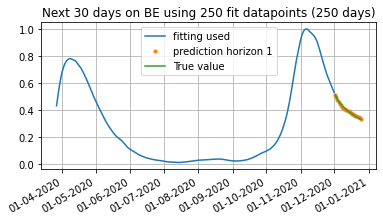

In [23]:
for loc in all_prediction:
    for i, pred in enumerate(all_prediction[loc]):
        prediction = pred
        fit = datapoints[loc][1][:max(fit_used[i])+1][:,0].reshape(-1)
        target_expected = np.array(all_targets[loc][i])
        
        fit_dates = fit_dates_used[i][:,0]
        prediction_dates = prediction_dates_used[i][:,0]
        
        fig = plt.figure(figsize=(6,3))
        plt.plot(fit_dates, fit, label="fitting used")
        plt.plot(prediction_dates, prediction[:,0], '.', label="prediction horizon 1")
        plt.plot(prediction_dates, target_expected[:,0], label="True value")
        
        ax = fig.axes[0]
        # set monthly locator
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        # set formatter
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
        # set font and rotation for date tick labels
        plt.gcf().autofmt_xdate()
        
        plt.legend()
        plt.grid()
        days_used = fit_first_days + i*fit_steps_days
        plt.title(f"Next {fit_steps_days} days on {loc} using {len(fit_used[i])} fit datapoints ({days_used} days)")
        #plt.savefig(f"fit_{len(fit_used[i])}.png", dpi=300)

In [24]:
x_dates

[datetime.date(2020, 3, 26),
 datetime.date(2020, 3, 27),
 datetime.date(2020, 3, 28),
 datetime.date(2020, 3, 29),
 datetime.date(2020, 3, 30),
 datetime.date(2020, 3, 31),
 datetime.date(2020, 4, 1),
 datetime.date(2020, 4, 2),
 datetime.date(2020, 4, 3),
 datetime.date(2020, 4, 4),
 datetime.date(2020, 4, 5),
 datetime.date(2020, 4, 6),
 datetime.date(2020, 4, 7),
 datetime.date(2020, 4, 8),
 datetime.date(2020, 4, 9),
 datetime.date(2020, 4, 10),
 datetime.date(2020, 4, 11),
 datetime.date(2020, 4, 12),
 datetime.date(2020, 4, 13),
 datetime.date(2020, 4, 14),
 datetime.date(2020, 4, 15),
 datetime.date(2020, 4, 16),
 datetime.date(2020, 4, 17),
 datetime.date(2020, 4, 18),
 datetime.date(2020, 4, 19),
 datetime.date(2020, 4, 20),
 datetime.date(2020, 4, 21),
 datetime.date(2020, 4, 22),
 datetime.date(2020, 4, 23),
 datetime.date(2020, 4, 24),
 datetime.date(2020, 4, 25),
 datetime.date(2020, 4, 26),
 datetime.date(2020, 4, 27),
 datetime.date(2020, 4, 28),
 datetime.date(2020, 4,

# Comparison between several models

In [25]:
end_train = "2020-09-15"  # dates with respect to x, included
end_valid = "2020-11-20"
end_test = "2020-12-25"

date_f = "%Y-%m-%d"
max_dates = [datetime.strptime(end_train, date_f).date(),
            datetime.strptime(end_valid, date_f).date(),
            datetime.strptime(end_test, date_f).date()]
max_dates[-1] = min(max(x_dates), max_dates[-1])
max_train_idx, max_valid_idx, max_test_idx = np.where(np.isin(x_dates, max_dates))[0]

train_idx = list(reversed(range(max_train_idx, -1, -n_forecast)))
valid_idx = list(range(max_train_idx+1, max_valid_idx+1))
test_idx = list(range(max_valid_idx+1, max_test_idx+1))

def train_generator():
    return data_generator(train_idx)

def validation_generator():
    return data_generator(valid_idx)

def test_generator():
    return data_generator(valid_idx)

train_datapoints = {loc: data_value_region(train_idx, loc) for loc in geocodes}
valid_datapoints = {loc: data_value_region(valid_idx, loc) for loc in geocodes}
test_datapoints = {loc: data_value_region(test_idx, loc) for loc in geocodes}

## Toy model

In [26]:
model = Sequential()
model.add(LSTM(32, input_shape=(n_samples, n_features), return_sequences=True))
model.add(LSTM(32, input_shape=(n_samples, n_features), return_sequences=False))
model.add(Dense(n_forecast))
LSTMModel = model
print(model.output_shape)

(None, 1)


In [27]:
#history = model.fit(x_train, y_train, epochs=400, verbose=1, shuffle=False)
LSTMModel.compile(loss="mse", optimizer='adam')
history = LSTMModel.fit(train_generator(), steps_per_epoch=len(train_datapoints), epochs=epochs, verbose=1, shuffle=False, 
          validation_data=validation_generator(),
          validation_steps=len(valid_datapoints))

Epoch 1/1000
1/1 [==============================] - 1s 524ms/step - loss: 0.1204 - val_loss: 0.3649
Epoch 2/1000
1/1 [==============================] - 0s 18ms/step - loss: 0.1050 - val_loss: 0.3243
Epoch 3/1000
1/1 [==============================] - 0s 17ms/step - loss: 0.0911 - val_loss: 0.2865
Epoch 4/1000
1/1 [==============================] - 0s 18ms/step - loss: 0.0786 - val_loss: 0.2512
Epoch 5/1000
1/1 [==============================] - 0s 21ms/step - loss: 0.0672 - val_loss: 0.2182
Epoch 6/1000
1/1 [==============================] - 0s 19ms/step - loss: 0.0571 - val_loss: 0.1873
Epoch 7/1000
1/1 [==============================] - 0s 19ms/step - loss: 0.0481 - val_loss: 0.1586
Epoch 8/1000
1/1 [==============================] - 0s 18ms/step - loss: 0.0404 - val_loss: 0.1320
Epoch 9/1000
1/1 [==============================] - 0s 17ms/step - loss: 0.0338 - val_loss: 0.1077
Epoch 10/1000
1/1 [==============================] - 0s 18ms/step - loss: 0.0286 - val_loss: 0.0860
Epoch 11

1/1 [==============================] - 0s 18ms/step - loss: 0.0056 - val_loss: 0.0174
Epoch 84/1000
1/1 [==============================] - 0s 18ms/step - loss: 0.0055 - val_loss: 0.0171
Epoch 85/1000
1/1 [==============================] - 0s 19ms/step - loss: 0.0054 - val_loss: 0.0170
Epoch 86/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.0053 - val_loss: 0.0168
Epoch 87/1000
1/1 [==============================] - 0s 18ms/step - loss: 0.0052 - val_loss: 0.0167
Epoch 88/1000
1/1 [==============================] - 0s 18ms/step - loss: 0.0051 - val_loss: 0.0166
Epoch 89/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.0051 - val_loss: 0.0164
Epoch 90/1000
1/1 [==============================] - 0s 17ms/step - loss: 0.0050 - val_loss: 0.0162
Epoch 91/1000
1/1 [==============================] - 0s 18ms/step - loss: 0.0049 - val_loss: 0.0159
Epoch 92/1000
1/1 [==============================] - 0s 17ms/step - loss: 0.0047 - val_loss: 0.0156
Epoch 93/1000


Epoch 164/1000
1/1 [==============================] - 0s 19ms/step - loss: 8.7117e-04 - val_loss: 0.0026
Epoch 165/1000
1/1 [==============================] - 0s 19ms/step - loss: 8.6227e-04 - val_loss: 0.0025
Epoch 166/1000
1/1 [==============================] - 0s 16ms/step - loss: 8.5346e-04 - val_loss: 0.0025
Epoch 167/1000
1/1 [==============================] - 0s 18ms/step - loss: 8.4477e-04 - val_loss: 0.0025
Epoch 168/1000
1/1 [==============================] - 0s 18ms/step - loss: 8.3619e-04 - val_loss: 0.0024
Epoch 169/1000
1/1 [==============================] - 0s 18ms/step - loss: 8.2772e-04 - val_loss: 0.0024
Epoch 170/1000
1/1 [==============================] - 0s 19ms/step - loss: 8.1936e-04 - val_loss: 0.0024
Epoch 171/1000
1/1 [==============================] - 0s 19ms/step - loss: 8.1111e-04 - val_loss: 0.0024
Epoch 172/1000
1/1 [==============================] - 0s 18ms/step - loss: 8.0294e-04 - val_loss: 0.0023
Epoch 173/1000
1/1 [==============================] - 0

1/1 [==============================] - 0s 18ms/step - loss: 3.1186e-04 - val_loss: 0.0018
Epoch 243/1000
1/1 [==============================] - 0s 16ms/step - loss: 3.0630e-04 - val_loss: 0.0018
Epoch 244/1000
1/1 [==============================] - 0s 18ms/step - loss: 3.0081e-04 - val_loss: 0.0018
Epoch 245/1000
1/1 [==============================] - 0s 18ms/step - loss: 2.9539e-04 - val_loss: 0.0019
Epoch 246/1000
1/1 [==============================] - 0s 18ms/step - loss: 2.9004e-04 - val_loss: 0.0019
Epoch 247/1000
1/1 [==============================] - 0s 17ms/step - loss: 2.8475e-04 - val_loss: 0.0019
Epoch 248/1000
1/1 [==============================] - 0s 17ms/step - loss: 2.7954e-04 - val_loss: 0.0019
Epoch 249/1000
1/1 [==============================] - 0s 18ms/step - loss: 2.7439e-04 - val_loss: 0.0019
Epoch 250/1000
1/1 [==============================] - 0s 16ms/step - loss: 2.6931e-04 - val_loss: 0.0019
Epoch 251/1000
1/1 [==============================] - 0s 17ms/step - l

1/1 [==============================] - 0s 16ms/step - loss: 6.4944e-05 - val_loss: 0.0022
Epoch 321/1000
1/1 [==============================] - 0s 20ms/step - loss: 6.3995e-05 - val_loss: 0.0022
Epoch 322/1000
1/1 [==============================] - 0s 19ms/step - loss: 6.3087e-05 - val_loss: 0.0022
Epoch 323/1000
1/1 [==============================] - 0s 18ms/step - loss: 6.2218e-05 - val_loss: 0.0022
Epoch 324/1000
1/1 [==============================] - 0s 16ms/step - loss: 6.1386e-05 - val_loss: 0.0022
Epoch 325/1000
1/1 [==============================] - 0s 18ms/step - loss: 6.0591e-05 - val_loss: 0.0023
Epoch 326/1000
1/1 [==============================] - 0s 17ms/step - loss: 5.9831e-05 - val_loss: 0.0023
Epoch 327/1000
1/1 [==============================] - 0s 16ms/step - loss: 5.9105e-05 - val_loss: 0.0023
Epoch 328/1000
1/1 [==============================] - 0s 17ms/step - loss: 5.8411e-05 - val_loss: 0.0023
Epoch 329/1000
1/1 [==============================] - 0s 19ms/step - l

1/1 [==============================] - 0s 17ms/step - loss: 4.1448e-05 - val_loss: 0.0024
Epoch 399/1000
1/1 [==============================] - 0s 17ms/step - loss: 4.1341e-05 - val_loss: 0.0024
Epoch 400/1000
1/1 [==============================] - 0s 18ms/step - loss: 4.1236e-05 - val_loss: 0.0024
Epoch 401/1000
1/1 [==============================] - 0s 17ms/step - loss: 4.1131e-05 - val_loss: 0.0024
Epoch 402/1000
1/1 [==============================] - 0s 17ms/step - loss: 4.1028e-05 - val_loss: 0.0024
Epoch 403/1000
1/1 [==============================] - 0s 17ms/step - loss: 4.0925e-05 - val_loss: 0.0024
Epoch 404/1000
1/1 [==============================] - 0s 18ms/step - loss: 4.0824e-05 - val_loss: 0.0024
Epoch 405/1000
1/1 [==============================] - 0s 17ms/step - loss: 4.0724e-05 - val_loss: 0.0024
Epoch 406/1000
1/1 [==============================] - 0s 18ms/step - loss: 4.0624e-05 - val_loss: 0.0024
Epoch 407/1000
1/1 [==============================] - 0s 17ms/step - l

1/1 [==============================] - 0s 17ms/step - loss: 3.5538e-05 - val_loss: 0.0023
Epoch 477/1000
1/1 [==============================] - 0s 17ms/step - loss: 3.5486e-05 - val_loss: 0.0023
Epoch 478/1000
1/1 [==============================] - 0s 17ms/step - loss: 3.5433e-05 - val_loss: 0.0023
Epoch 479/1000
1/1 [==============================] - 0s 18ms/step - loss: 3.5381e-05 - val_loss: 0.0023
Epoch 480/1000
1/1 [==============================] - 0s 18ms/step - loss: 3.5330e-05 - val_loss: 0.0023
Epoch 481/1000
1/1 [==============================] - 0s 17ms/step - loss: 3.5279e-05 - val_loss: 0.0023
Epoch 482/1000
1/1 [==============================] - 0s 18ms/step - loss: 3.5228e-05 - val_loss: 0.0023
Epoch 483/1000
1/1 [==============================] - 0s 18ms/step - loss: 3.5177e-05 - val_loss: 0.0023
Epoch 484/1000
1/1 [==============================] - 0s 19ms/step - loss: 3.5127e-05 - val_loss: 0.0023
Epoch 485/1000
1/1 [==============================] - 0s 17ms/step - l

1/1 [==============================] - 0s 17ms/step - loss: 3.2297e-05 - val_loss: 0.0023
Epoch 555/1000
1/1 [==============================] - 0s 18ms/step - loss: 3.2264e-05 - val_loss: 0.0023
Epoch 556/1000
1/1 [==============================] - 0s 17ms/step - loss: 3.2231e-05 - val_loss: 0.0023
Epoch 557/1000
1/1 [==============================] - 0s 17ms/step - loss: 3.2198e-05 - val_loss: 0.0023
Epoch 558/1000
1/1 [==============================] - 0s 16ms/step - loss: 3.2165e-05 - val_loss: 0.0023
Epoch 559/1000
1/1 [==============================] - 0s 17ms/step - loss: 3.2133e-05 - val_loss: 0.0023
Epoch 560/1000
1/1 [==============================] - 0s 17ms/step - loss: 3.2103e-05 - val_loss: 0.0023
Epoch 561/1000
1/1 [==============================] - 0s 16ms/step - loss: 3.2075e-05 - val_loss: 0.0023
Epoch 562/1000
1/1 [==============================] - 0s 18ms/step - loss: 3.2052e-05 - val_loss: 0.0023
Epoch 563/1000
1/1 [==============================] - 0s 18ms/step - l

1/1 [==============================] - 0s 20ms/step - loss: 3.0055e-05 - val_loss: 0.0022
Epoch 633/1000
1/1 [==============================] - 0s 19ms/step - loss: 3.0029e-05 - val_loss: 0.0022
Epoch 634/1000
1/1 [==============================] - 0s 19ms/step - loss: 3.0004e-05 - val_loss: 0.0022
Epoch 635/1000
1/1 [==============================] - 0s 16ms/step - loss: 2.9980e-05 - val_loss: 0.0022
Epoch 636/1000
1/1 [==============================] - 0s 18ms/step - loss: 2.9954e-05 - val_loss: 0.0022
Epoch 637/1000
1/1 [==============================] - 0s 18ms/step - loss: 2.9928e-05 - val_loss: 0.0022
Epoch 638/1000
1/1 [==============================] - 0s 16ms/step - loss: 2.9901e-05 - val_loss: 0.0022
Epoch 639/1000
1/1 [==============================] - 0s 19ms/step - loss: 2.9875e-05 - val_loss: 0.0022
Epoch 640/1000
1/1 [==============================] - 0s 18ms/step - loss: 2.9850e-05 - val_loss: 0.0022
Epoch 641/1000
1/1 [==============================] - 0s 18ms/step - l

1/1 [==============================] - 0s 18ms/step - loss: 2.8163e-05 - val_loss: 0.0022
Epoch 711/1000
1/1 [==============================] - 0s 18ms/step - loss: 2.8140e-05 - val_loss: 0.0022
Epoch 712/1000
1/1 [==============================] - 0s 16ms/step - loss: 2.8117e-05 - val_loss: 0.0022
Epoch 713/1000
1/1 [==============================] - 0s 18ms/step - loss: 2.8094e-05 - val_loss: 0.0022
Epoch 714/1000
1/1 [==============================] - 0s 19ms/step - loss: 2.8072e-05 - val_loss: 0.0022
Epoch 715/1000
1/1 [==============================] - 0s 18ms/step - loss: 2.8049e-05 - val_loss: 0.0022
Epoch 716/1000
1/1 [==============================] - 0s 17ms/step - loss: 2.8026e-05 - val_loss: 0.0022
Epoch 717/1000
1/1 [==============================] - 0s 18ms/step - loss: 2.8003e-05 - val_loss: 0.0022
Epoch 718/1000
1/1 [==============================] - 0s 18ms/step - loss: 2.7981e-05 - val_loss: 0.0022
Epoch 719/1000
1/1 [==============================] - 0s 18ms/step - l

1/1 [==============================] - 0s 20ms/step - loss: 2.6578e-05 - val_loss: 0.0022
Epoch 789/1000
1/1 [==============================] - 0s 18ms/step - loss: 2.6503e-05 - val_loss: 0.0022
Epoch 790/1000
1/1 [==============================] - 0s 17ms/step - loss: 2.6463e-05 - val_loss: 0.0022
Epoch 791/1000
1/1 [==============================] - 0s 17ms/step - loss: 2.6464e-05 - val_loss: 0.0022
Epoch 792/1000
1/1 [==============================] - 0s 17ms/step - loss: 2.6478e-05 - val_loss: 0.0022
Epoch 793/1000
1/1 [==============================] - 0s 17ms/step - loss: 2.6468e-05 - val_loss: 0.0022
Epoch 794/1000
1/1 [==============================] - 0s 17ms/step - loss: 2.6429e-05 - val_loss: 0.0022
Epoch 795/1000
1/1 [==============================] - 0s 18ms/step - loss: 2.6380e-05 - val_loss: 0.0022
Epoch 796/1000
1/1 [==============================] - 0s 16ms/step - loss: 2.6347e-05 - val_loss: 0.0022
Epoch 797/1000
1/1 [==============================] - 0s 18ms/step - l

1/1 [==============================] - 0s 17ms/step - loss: 2.5063e-05 - val_loss: 0.0021
Epoch 867/1000
1/1 [==============================] - 0s 18ms/step - loss: 2.5046e-05 - val_loss: 0.0021
Epoch 868/1000
1/1 [==============================] - 0s 20ms/step - loss: 2.5028e-05 - val_loss: 0.0021
Epoch 869/1000
1/1 [==============================] - 0s 19ms/step - loss: 2.5011e-05 - val_loss: 0.0021
Epoch 870/1000
1/1 [==============================] - 0s 16ms/step - loss: 2.4993e-05 - val_loss: 0.0021
Epoch 871/1000
1/1 [==============================] - 0s 19ms/step - loss: 2.4976e-05 - val_loss: 0.0021
Epoch 872/1000
1/1 [==============================] - 0s 18ms/step - loss: 2.4959e-05 - val_loss: 0.0021
Epoch 873/1000
1/1 [==============================] - 0s 17ms/step - loss: 2.4942e-05 - val_loss: 0.0021
Epoch 874/1000
1/1 [==============================] - 0s 17ms/step - loss: 2.4924e-05 - val_loss: 0.0021
Epoch 875/1000
1/1 [==============================] - 0s 19ms/step - l

1/1 [==============================] - 0s 18ms/step - loss: 2.4072e-05 - val_loss: 0.0021
Epoch 945/1000
1/1 [==============================] - 0s 18ms/step - loss: 2.3834e-05 - val_loss: 0.0021
Epoch 946/1000
1/1 [==============================] - 0s 16ms/step - loss: 2.3767e-05 - val_loss: 0.0021
Epoch 947/1000
1/1 [==============================] - 0s 19ms/step - loss: 2.3867e-05 - val_loss: 0.0022
Epoch 948/1000
1/1 [==============================] - 0s 18ms/step - loss: 2.3986e-05 - val_loss: 0.0021
Epoch 949/1000
1/1 [==============================] - 0s 16ms/step - loss: 2.3986e-05 - val_loss: 0.0022
Epoch 950/1000
1/1 [==============================] - 0s 18ms/step - loss: 2.3865e-05 - val_loss: 0.0021
Epoch 951/1000
1/1 [==============================] - 0s 19ms/step - loss: 2.3727e-05 - val_loss: 0.0021
Epoch 952/1000
1/1 [==============================] - 0s 19ms/step - loss: 2.3673e-05 - val_loss: 0.0021
Epoch 953/1000
1/1 [==============================] - 0s 17ms/step - l

TEST BE
MSE =  0.0005386487356894893
MAE =  0.02012830908283914


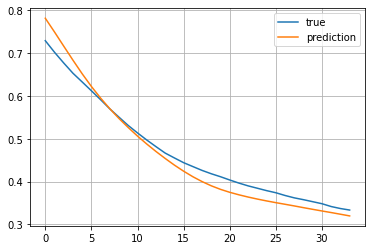

In [28]:
"""for loc in train_datapoints:
    print("TRAINING", loc)
    x, y = train_datapoints[loc]
    yp = model.predict(x)

    plt.plot(y.reshape(-1), label='true')
    plt.plot(yp.reshape(-1), label='prediction')
    plt.legend()
    plt.grid()
    plt.show()
    
for loc in valid_datapoints:
    print("VALIDATION", loc)
    x, y = valid_datapoints[loc]
    yp = model.predict(x)

    plt.plot(y.reshape(-1), label='true')
    plt.plot(yp.reshape(-1), label='prediction')
    plt.legend()
    plt.grid()
    plt.show()"""

for loc in test_datapoints:
    MSE = 0
    MAE = 0
    print("TEST", loc)
    x, y = test_datapoints[loc]
    yp = model.predict(x)
    MSE = mean_squared_error(y.reshape(-1), yp.reshape(-1))
    MAE = mean_absolute_error(y.reshape(-1), yp.reshape(-1))
    print("MSE = ", MSE)
    print("MAE = ", MAE)
    plt.plot(y.reshape(-1), label='true')
    plt.plot(yp.reshape(-1), label='prediction')
    plt.legend()
    plt.grid()
    plt.show()

In [29]:
# Let's use the validation set

## Base line models
### MultiStepLastBaseline
This model repeats the last value of hospitalisations `n_forecast` time

In [30]:
class MultiStepLastBaseline(tf.keras.Model):
    """
    repeat the last hospitalisations given as input n_forecast time
    """
    def call(self, inputs):
        a = inputs[:, -1:, target_idx:target_idx+1]  # target of the last days
        return tf.tile(
            a,
            [1, n_forecast, 1]   # repeat target n_forecast time
        )

BaselineModel = MultiStepLastBaseline()
BaselineModel.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

## Linear regression
linear regression of the last `n_sample` days used to predict the next `n_forecast` days

In [31]:
class LinearRegressionHospi(tf.keras.Model):
    """
    repeat the last hospitalisations given as input n_forecast time
    """
    def predict(self, inputs):
        y = inputs[:, :, target_idx]  # target of the last days
        length = len(inputs)
        x = np.arange(n_samples).reshape(-1,1)  # dates of the target
        result = np.zeros((length, n_forecast))
        for i in range(length):
            regr = LinearRegression().fit(x,y[i])  # linear regression of (days, target)
            result[i] = regr.predict(np.arange(n_samples, n_samples+n_forecast).reshape(-1,1))
        return result
        

## 1 fully connected layer (Dense model)

In [32]:
DenseModel = Sequential()
DenseModel.add(Lambda(lambda x: x[:,:,target_idx]))  # select only the target of the previous days
DenseModel.add(Dense(n_forecast))   # predict the next target based on the previous ones
DenseModel.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

In [33]:
LinearModel_history = DenseModel.fit(train_generator(), steps_per_epoch=len(train_datapoints), epochs=epochs, verbose=1, shuffle=False, 
          validation_data=validation_generator(),
          validation_steps=len(valid_datapoints))

Epoch 1/1000
1/1 [==============================] - 0s 71ms/step - loss: 0.1807 - mean_absolute_error: 0.2688 - val_loss: 0.3535 - val_mean_absolute_error: 0.3693
Epoch 2/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.1673 - mean_absolute_error: 0.2570 - val_loss: 0.3332 - val_mean_absolute_error: 0.3550
Epoch 3/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.1581 - mean_absolute_error: 0.2486 - val_loss: 0.3169 - val_mean_absolute_error: 0.3431
Epoch 4/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.1507 - mean_absolute_error: 0.2416 - val_loss: 0.3030 - val_mean_absolute_error: 0.3327
Epoch 5/1000
1/1 [==============================] - 0s 17ms/step - loss: 0.1444 - mean_absolute_error: 0.2355 - val_loss: 0.2906 - val_mean_absolute_error: 0.3232
Epoch 6/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.1387 - mean_absolute_error: 0.2300 - val_loss: 0.2794 - val_mean_absolute_error: 0.3144
Epoch 7/1000
1/1 [====

1/1 [==============================] - 0s 18ms/step - loss: 0.0307 - mean_absolute_error: 0.1185 - val_loss: 0.0591 - val_mean_absolute_error: 0.1743
Epoch 52/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.0296 - mean_absolute_error: 0.1170 - val_loss: 0.0571 - val_mean_absolute_error: 0.1731
Epoch 53/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.0285 - mean_absolute_error: 0.1155 - val_loss: 0.0551 - val_mean_absolute_error: 0.1720
Epoch 54/1000
1/1 [==============================] - 0s 17ms/step - loss: 0.0275 - mean_absolute_error: 0.1141 - val_loss: 0.0533 - val_mean_absolute_error: 0.1708
Epoch 55/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.0265 - mean_absolute_error: 0.1126 - val_loss: 0.0515 - val_mean_absolute_error: 0.1697
Epoch 56/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.0256 - mean_absolute_error: 0.1112 - val_loss: 0.0499 - val_mean_absolute_error: 0.1686
Epoch 57/1000
1/1 [===========

1/1 [==============================] - 0s 18ms/step - loss: 0.0087 - mean_absolute_error: 0.0606 - val_loss: 0.0262 - val_mean_absolute_error: 0.1344
Epoch 102/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.0085 - mean_absolute_error: 0.0596 - val_loss: 0.0260 - val_mean_absolute_error: 0.1336
Epoch 103/1000
1/1 [==============================] - 0s 17ms/step - loss: 0.0084 - mean_absolute_error: 0.0587 - val_loss: 0.0259 - val_mean_absolute_error: 0.1328
Epoch 104/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.0083 - mean_absolute_error: 0.0578 - val_loss: 0.0257 - val_mean_absolute_error: 0.1320
Epoch 105/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.0082 - mean_absolute_error: 0.0570 - val_loss: 0.0256 - val_mean_absolute_error: 0.1312
Epoch 106/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.0081 - mean_absolute_error: 0.0561 - val_loss: 0.0254 - val_mean_absolute_error: 0.1303
Epoch 107/1000
1/1 [=====

Epoch 151/1000
1/1 [==============================] - 0s 18ms/step - loss: 0.0039 - mean_absolute_error: 0.0268 - val_loss: 0.0149 - val_mean_absolute_error: 0.0884
Epoch 152/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.0039 - mean_absolute_error: 0.0265 - val_loss: 0.0147 - val_mean_absolute_error: 0.0875
Epoch 153/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.0038 - mean_absolute_error: 0.0261 - val_loss: 0.0145 - val_mean_absolute_error: 0.0866
Epoch 154/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.0037 - mean_absolute_error: 0.0258 - val_loss: 0.0143 - val_mean_absolute_error: 0.0857
Epoch 155/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.0037 - mean_absolute_error: 0.0256 - val_loss: 0.0141 - val_mean_absolute_error: 0.0848
Epoch 156/1000
1/1 [==============================] - 0s 18ms/step - loss: 0.0036 - mean_absolute_error: 0.0253 - val_loss: 0.0138 - val_mean_absolute_error: 0.0840
Epoch 157/

Epoch 201/1000
1/1 [==============================] - 0s 17ms/step - loss: 0.0017 - mean_absolute_error: 0.0185 - val_loss: 0.0070 - val_mean_absolute_error: 0.0558
Epoch 202/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.0017 - mean_absolute_error: 0.0185 - val_loss: 0.0069 - val_mean_absolute_error: 0.0553
Epoch 203/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.0017 - mean_absolute_error: 0.0185 - val_loss: 0.0068 - val_mean_absolute_error: 0.0549
Epoch 204/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.0017 - mean_absolute_error: 0.0185 - val_loss: 0.0067 - val_mean_absolute_error: 0.0545
Epoch 205/1000
1/1 [==============================] - 0s 18ms/step - loss: 0.0016 - mean_absolute_error: 0.0185 - val_loss: 0.0066 - val_mean_absolute_error: 0.0540
Epoch 206/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.0016 - mean_absolute_error: 0.0184 - val_loss: 0.0065 - val_mean_absolute_error: 0.0536
Epoch 207/

Epoch 251/1000
1/1 [==============================] - 0s 17ms/step - loss: 0.0012 - mean_absolute_error: 0.0190 - val_loss: 0.0043 - val_mean_absolute_error: 0.0436
Epoch 252/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.0012 - mean_absolute_error: 0.0192 - val_loss: 0.0041 - val_mean_absolute_error: 0.0446
Epoch 253/1000
1/1 [==============================] - 0s 17ms/step - loss: 0.0012 - mean_absolute_error: 0.0190 - val_loss: 0.0042 - val_mean_absolute_error: 0.0434
Epoch 254/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.0012 - mean_absolute_error: 0.0192 - val_loss: 0.0041 - val_mean_absolute_error: 0.0444
Epoch 255/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.0012 - mean_absolute_error: 0.0190 - val_loss: 0.0042 - val_mean_absolute_error: 0.0431
Epoch 256/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.0012 - mean_absolute_error: 0.0192 - val_loss: 0.0040 - val_mean_absolute_error: 0.0443
Epoch 257/

Epoch 301/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.0011 - mean_absolute_error: 0.0185 - val_loss: 0.0036 - val_mean_absolute_error: 0.0402
Epoch 302/1000
1/1 [==============================] - 0s 17ms/step - loss: 0.0011 - mean_absolute_error: 0.0188 - val_loss: 0.0035 - val_mean_absolute_error: 0.0415
Epoch 303/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.0011 - mean_absolute_error: 0.0185 - val_loss: 0.0036 - val_mean_absolute_error: 0.0401
Epoch 304/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.0011 - mean_absolute_error: 0.0188 - val_loss: 0.0035 - val_mean_absolute_error: 0.0414
Epoch 305/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.0011 - mean_absolute_error: 0.0184 - val_loss: 0.0036 - val_mean_absolute_error: 0.0400
Epoch 306/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.0011 - mean_absolute_error: 0.0187 - val_loss: 0.0035 - val_mean_absolute_error: 0.0413
Epoch 307/

1/1 [==============================] - 0s 16ms/step - loss: 9.9160e-04 - mean_absolute_error: 0.0179 - val_loss: 0.0032 - val_mean_absolute_error: 0.0397
Epoch 351/1000
1/1 [==============================] - 0s 17ms/step - loss: 9.8954e-04 - mean_absolute_error: 0.0176 - val_loss: 0.0033 - val_mean_absolute_error: 0.0382
Epoch 352/1000
1/1 [==============================] - 0s 16ms/step - loss: 9.8743e-04 - mean_absolute_error: 0.0179 - val_loss: 0.0032 - val_mean_absolute_error: 0.0396
Epoch 353/1000
1/1 [==============================] - 0s 15ms/step - loss: 9.8538e-04 - mean_absolute_error: 0.0175 - val_loss: 0.0033 - val_mean_absolute_error: 0.0382
Epoch 354/1000
1/1 [==============================] - 0s 16ms/step - loss: 9.8328e-04 - mean_absolute_error: 0.0178 - val_loss: 0.0032 - val_mean_absolute_error: 0.0395
Epoch 355/1000
1/1 [==============================] - 0s 16ms/step - loss: 9.8125e-04 - mean_absolute_error: 0.0175 - val_loss: 0.0032 - val_mean_absolute_error: 0.0381
E

1/1 [==============================] - 0s 18ms/step - loss: 8.9646e-04 - mean_absolute_error: 0.0170 - val_loss: 0.0029 - val_mean_absolute_error: 0.0380
Epoch 399/1000
1/1 [==============================] - 0s 16ms/step - loss: 8.9461e-04 - mean_absolute_error: 0.0167 - val_loss: 0.0030 - val_mean_absolute_error: 0.0366
Epoch 400/1000
1/1 [==============================] - 0s 15ms/step - loss: 8.9270e-04 - mean_absolute_error: 0.0170 - val_loss: 0.0029 - val_mean_absolute_error: 0.0379
Epoch 401/1000
1/1 [==============================] - 0s 17ms/step - loss: 8.9086e-04 - mean_absolute_error: 0.0166 - val_loss: 0.0030 - val_mean_absolute_error: 0.0365
Epoch 402/1000
1/1 [==============================] - 0s 16ms/step - loss: 8.8897e-04 - mean_absolute_error: 0.0169 - val_loss: 0.0029 - val_mean_absolute_error: 0.0379
Epoch 403/1000
1/1 [==============================] - 0s 16ms/step - loss: 8.8713e-04 - mean_absolute_error: 0.0166 - val_loss: 0.0030 - val_mean_absolute_error: 0.0364
E

1/1 [==============================] - 0s 15ms/step - loss: 8.1075e-04 - mean_absolute_error: 0.0161 - val_loss: 0.0027 - val_mean_absolute_error: 0.0365
Epoch 447/1000
1/1 [==============================] - 0s 15ms/step - loss: 8.0908e-04 - mean_absolute_error: 0.0158 - val_loss: 0.0028 - val_mean_absolute_error: 0.0350
Epoch 448/1000
1/1 [==============================] - 0s 17ms/step - loss: 8.0737e-04 - mean_absolute_error: 0.0161 - val_loss: 0.0027 - val_mean_absolute_error: 0.0364
Epoch 449/1000
1/1 [==============================] - 0s 16ms/step - loss: 8.0571e-04 - mean_absolute_error: 0.0158 - val_loss: 0.0027 - val_mean_absolute_error: 0.0350
Epoch 450/1000
1/1 [==============================] - 0s 16ms/step - loss: 8.0400e-04 - mean_absolute_error: 0.0160 - val_loss: 0.0027 - val_mean_absolute_error: 0.0363
Epoch 451/1000
1/1 [==============================] - 0s 16ms/step - loss: 8.0235e-04 - mean_absolute_error: 0.0157 - val_loss: 0.0027 - val_mean_absolute_error: 0.0349
E

1/1 [==============================] - 0s 17ms/step - loss: 7.3359e-04 - mean_absolute_error: 0.0153 - val_loss: 0.0025 - val_mean_absolute_error: 0.0350
Epoch 495/1000
1/1 [==============================] - 0s 16ms/step - loss: 7.3209e-04 - mean_absolute_error: 0.0150 - val_loss: 0.0025 - val_mean_absolute_error: 0.0336
Epoch 496/1000
1/1 [==============================] - 0s 15ms/step - loss: 7.3055e-04 - mean_absolute_error: 0.0152 - val_loss: 0.0024 - val_mean_absolute_error: 0.0349
Epoch 497/1000
1/1 [==============================] - 0s 17ms/step - loss: 7.2905e-04 - mean_absolute_error: 0.0149 - val_loss: 0.0025 - val_mean_absolute_error: 0.0335
Epoch 498/1000
1/1 [==============================] - 0s 16ms/step - loss: 7.2752e-04 - mean_absolute_error: 0.0152 - val_loss: 0.0024 - val_mean_absolute_error: 0.0349
Epoch 499/1000
1/1 [==============================] - 0s 16ms/step - loss: 7.2603e-04 - mean_absolute_error: 0.0149 - val_loss: 0.0025 - val_mean_absolute_error: 0.0334
E

1/1 [==============================] - 0s 17ms/step - loss: 6.6417e-04 - mean_absolute_error: 0.0145 - val_loss: 0.0023 - val_mean_absolute_error: 0.0336
Epoch 543/1000
1/1 [==============================] - 0s 15ms/step - loss: 6.6282e-04 - mean_absolute_error: 0.0142 - val_loss: 0.0023 - val_mean_absolute_error: 0.0322
Epoch 544/1000
1/1 [==============================] - 0s 17ms/step - loss: 6.6144e-04 - mean_absolute_error: 0.0144 - val_loss: 0.0022 - val_mean_absolute_error: 0.0335
Epoch 545/1000
1/1 [==============================] - 0s 16ms/step - loss: 6.6009e-04 - mean_absolute_error: 0.0142 - val_loss: 0.0023 - val_mean_absolute_error: 0.0321
Epoch 546/1000
1/1 [==============================] - 0s 17ms/step - loss: 6.5871e-04 - mean_absolute_error: 0.0144 - val_loss: 0.0022 - val_mean_absolute_error: 0.0335
Epoch 547/1000
1/1 [==============================] - 0s 16ms/step - loss: 6.5737e-04 - mean_absolute_error: 0.0141 - val_loss: 0.0023 - val_mean_absolute_error: 0.0321
E

1/1 [==============================] - 0s 18ms/step - loss: 6.0175e-04 - mean_absolute_error: 0.0137 - val_loss: 0.0021 - val_mean_absolute_error: 0.0323
Epoch 591/1000
1/1 [==============================] - 0s 18ms/step - loss: 6.0054e-04 - mean_absolute_error: 0.0135 - val_loss: 0.0022 - val_mean_absolute_error: 0.0309
Epoch 592/1000
1/1 [==============================] - 0s 15ms/step - loss: 5.9930e-04 - mean_absolute_error: 0.0137 - val_loss: 0.0021 - val_mean_absolute_error: 0.0322
Epoch 593/1000
1/1 [==============================] - 0s 16ms/step - loss: 5.9809e-04 - mean_absolute_error: 0.0135 - val_loss: 0.0021 - val_mean_absolute_error: 0.0308
Epoch 594/1000
1/1 [==============================] - 0s 16ms/step - loss: 5.9685e-04 - mean_absolute_error: 0.0136 - val_loss: 0.0021 - val_mean_absolute_error: 0.0322
Epoch 595/1000
1/1 [==============================] - 0s 17ms/step - loss: 5.9564e-04 - mean_absolute_error: 0.0134 - val_loss: 0.0021 - val_mean_absolute_error: 0.0308
E

1/1 [==============================] - 0s 16ms/step - loss: 5.4566e-04 - mean_absolute_error: 0.0130 - val_loss: 0.0019 - val_mean_absolute_error: 0.0310
Epoch 639/1000
1/1 [==============================] - 0s 15ms/step - loss: 5.4457e-04 - mean_absolute_error: 0.0128 - val_loss: 0.0020 - val_mean_absolute_error: 0.0297
Epoch 640/1000
1/1 [==============================] - 0s 17ms/step - loss: 5.4345e-04 - mean_absolute_error: 0.0130 - val_loss: 0.0019 - val_mean_absolute_error: 0.0310
Epoch 641/1000
1/1 [==============================] - 0s 17ms/step - loss: 5.4236e-04 - mean_absolute_error: 0.0128 - val_loss: 0.0020 - val_mean_absolute_error: 0.0296
Epoch 642/1000
1/1 [==============================] - 0s 17ms/step - loss: 5.4125e-04 - mean_absolute_error: 0.0129 - val_loss: 0.0019 - val_mean_absolute_error: 0.0309
Epoch 643/1000
1/1 [==============================] - 0s 16ms/step - loss: 5.4017e-04 - mean_absolute_error: 0.0128 - val_loss: 0.0020 - val_mean_absolute_error: 0.0296
E

1/1 [==============================] - 0s 16ms/step - loss: 4.9527e-04 - mean_absolute_error: 0.0123 - val_loss: 0.0018 - val_mean_absolute_error: 0.0298
Epoch 687/1000
1/1 [==============================] - 0s 17ms/step - loss: 4.9428e-04 - mean_absolute_error: 0.0122 - val_loss: 0.0018 - val_mean_absolute_error: 0.0285
Epoch 688/1000
1/1 [==============================] - 0s 16ms/step - loss: 4.9328e-04 - mean_absolute_error: 0.0123 - val_loss: 0.0018 - val_mean_absolute_error: 0.0298
Epoch 689/1000
1/1 [==============================] - 0s 16ms/step - loss: 4.9230e-04 - mean_absolute_error: 0.0122 - val_loss: 0.0018 - val_mean_absolute_error: 0.0285
Epoch 690/1000
1/1 [==============================] - 0s 15ms/step - loss: 4.9131e-04 - mean_absolute_error: 0.0122 - val_loss: 0.0018 - val_mean_absolute_error: 0.0297
Epoch 691/1000
1/1 [==============================] - 0s 16ms/step - loss: 4.9033e-04 - mean_absolute_error: 0.0122 - val_loss: 0.0018 - val_mean_absolute_error: 0.0284
E

1/1 [==============================] - 0s 16ms/step - loss: 4.5001e-04 - mean_absolute_error: 0.0117 - val_loss: 0.0016 - val_mean_absolute_error: 0.0287
Epoch 735/1000
1/1 [==============================] - 0s 17ms/step - loss: 4.4913e-04 - mean_absolute_error: 0.0116 - val_loss: 0.0017 - val_mean_absolute_error: 0.0275
Epoch 736/1000
1/1 [==============================] - 0s 15ms/step - loss: 4.4823e-04 - mean_absolute_error: 0.0116 - val_loss: 0.0016 - val_mean_absolute_error: 0.0287
Epoch 737/1000
1/1 [==============================] - 0s 16ms/step - loss: 4.4735e-04 - mean_absolute_error: 0.0116 - val_loss: 0.0017 - val_mean_absolute_error: 0.0274
Epoch 738/1000
1/1 [==============================] - 0s 16ms/step - loss: 4.4646e-04 - mean_absolute_error: 0.0116 - val_loss: 0.0016 - val_mean_absolute_error: 0.0286
Epoch 739/1000
1/1 [==============================] - 0s 17ms/step - loss: 4.4558e-04 - mean_absolute_error: 0.0116 - val_loss: 0.0017 - val_mean_absolute_error: 0.0274
E

1/1 [==============================] - 0s 21ms/step - loss: 4.0939e-04 - mean_absolute_error: 0.0111 - val_loss: 0.0015 - val_mean_absolute_error: 0.0276
Epoch 783/1000
1/1 [==============================] - 0s 19ms/step - loss: 4.0860e-04 - mean_absolute_error: 0.0111 - val_loss: 0.0016 - val_mean_absolute_error: 0.0265
Epoch 784/1000
1/1 [==============================] - 0s 19ms/step - loss: 4.0779e-04 - mean_absolute_error: 0.0110 - val_loss: 0.0015 - val_mean_absolute_error: 0.0276
Epoch 785/1000
1/1 [==============================] - 0s 16ms/step - loss: 4.0700e-04 - mean_absolute_error: 0.0111 - val_loss: 0.0016 - val_mean_absolute_error: 0.0264
Epoch 786/1000
1/1 [==============================] - 0s 22ms/step - loss: 4.0620e-04 - mean_absolute_error: 0.0110 - val_loss: 0.0015 - val_mean_absolute_error: 0.0275
Epoch 787/1000
1/1 [==============================] - 0s 18ms/step - loss: 4.0541e-04 - mean_absolute_error: 0.0110 - val_loss: 0.0016 - val_mean_absolute_error: 0.0264
E

1/1 [==============================] - 0s 15ms/step - loss: 3.7293e-04 - mean_absolute_error: 0.0105 - val_loss: 0.0014 - val_mean_absolute_error: 0.0266
Epoch 831/1000
1/1 [==============================] - 0s 15ms/step - loss: 3.7222e-04 - mean_absolute_error: 0.0105 - val_loss: 0.0015 - val_mean_absolute_error: 0.0255
Epoch 832/1000
1/1 [==============================] - 0s 16ms/step - loss: 3.7150e-04 - mean_absolute_error: 0.0105 - val_loss: 0.0014 - val_mean_absolute_error: 0.0266
Epoch 833/1000
1/1 [==============================] - 0s 17ms/step - loss: 3.7079e-04 - mean_absolute_error: 0.0105 - val_loss: 0.0015 - val_mean_absolute_error: 0.0255
Epoch 834/1000
1/1 [==============================] - 0s 15ms/step - loss: 3.7007e-04 - mean_absolute_error: 0.0105 - val_loss: 0.0014 - val_mean_absolute_error: 0.0265
Epoch 835/1000
1/1 [==============================] - 0s 16ms/step - loss: 3.6936e-04 - mean_absolute_error: 0.0105 - val_loss: 0.0015 - val_mean_absolute_error: 0.0254
E

1/1 [==============================] - 0s 15ms/step - loss: 3.4022e-04 - mean_absolute_error: 0.0100 - val_loss: 0.0013 - val_mean_absolute_error: 0.0256
Epoch 879/1000
1/1 [==============================] - 0s 17ms/step - loss: 3.3958e-04 - mean_absolute_error: 0.0101 - val_loss: 0.0014 - val_mean_absolute_error: 0.0247
Epoch 880/1000
1/1 [==============================] - 0s 16ms/step - loss: 3.3894e-04 - mean_absolute_error: 0.0099 - val_loss: 0.0013 - val_mean_absolute_error: 0.0256
Epoch 881/1000
1/1 [==============================] - 0s 16ms/step - loss: 3.3830e-04 - mean_absolute_error: 0.0100 - val_loss: 0.0014 - val_mean_absolute_error: 0.0246
Epoch 882/1000
1/1 [==============================] - 0s 16ms/step - loss: 3.3765e-04 - mean_absolute_error: 0.0099 - val_loss: 0.0013 - val_mean_absolute_error: 0.0256
Epoch 883/1000
1/1 [==============================] - 0s 17ms/step - loss: 3.3702e-04 - mean_absolute_error: 0.0100 - val_loss: 0.0014 - val_mean_absolute_error: 0.0246
E

1/1 [==============================] - 0s 16ms/step - loss: 3.1088e-04 - mean_absolute_error: 0.0095 - val_loss: 0.0012 - val_mean_absolute_error: 0.0247
Epoch 927/1000
1/1 [==============================] - 0s 16ms/step - loss: 3.1031e-04 - mean_absolute_error: 0.0096 - val_loss: 0.0013 - val_mean_absolute_error: 0.0239
Epoch 928/1000
1/1 [==============================] - ETA: 0s - loss: 3.0973e-04 - mean_absolute_error: 0.009 - 0s 16ms/step - loss: 3.0973e-04 - mean_absolute_error: 0.0095 - val_loss: 0.0012 - val_mean_absolute_error: 0.0247
Epoch 929/1000
1/1 [==============================] - 0s 16ms/step - loss: 3.0916e-04 - mean_absolute_error: 0.0096 - val_loss: 0.0013 - val_mean_absolute_error: 0.0238
Epoch 930/1000
1/1 [==============================] - 0s 16ms/step - loss: 3.0858e-04 - mean_absolute_error: 0.0094 - val_loss: 0.0012 - val_mean_absolute_error: 0.0247
Epoch 931/1000
1/1 [==============================] - 0s 15ms/step - loss: 3.0801e-04 - mean_absolute_error: 0.0

1/1 [==============================] - 0s 16ms/step - loss: 2.8456e-04 - mean_absolute_error: 0.0090 - val_loss: 0.0011 - val_mean_absolute_error: 0.0239
Epoch 975/1000
1/1 [==============================] - 0s 17ms/step - loss: 2.8405e-04 - mean_absolute_error: 0.0091 - val_loss: 0.0012 - val_mean_absolute_error: 0.0231
Epoch 976/1000
1/1 [==============================] - 0s 16ms/step - loss: 2.8353e-04 - mean_absolute_error: 0.0090 - val_loss: 0.0011 - val_mean_absolute_error: 0.0238
Epoch 977/1000
1/1 [==============================] - 0s 16ms/step - loss: 2.8302e-04 - mean_absolute_error: 0.0091 - val_loss: 0.0012 - val_mean_absolute_error: 0.0231
Epoch 978/1000
1/1 [==============================] - 0s 15ms/step - loss: 2.8250e-04 - mean_absolute_error: 0.0090 - val_loss: 0.0011 - val_mean_absolute_error: 0.0238
Epoch 979/1000
1/1 [==============================] - 0s 17ms/step - loss: 2.8199e-04 - mean_absolute_error: 0.0091 - val_loss: 0.0012 - val_mean_absolute_error: 0.0231
E

# Comparisons of the models

In [34]:
#LSTMModel = scan_object.best_model(metric='val_mse', asc=True)  # retrieve the best model from the scan
all_models = {
    'RepeatLast': BaselineModel,
    'LSTM': LSTMModel,
    'Dense': DenseModel,
    'Linear regression': LinearRegressionHospi()
}

def error_set(models, points, plot=True):
    y_predicted = {k:[] for k in models.keys()}
    y_true = []
    length = 0
    for loc in points:
        print(loc)
        length += 1
        x, y = points[loc]
        y = y.reshape(-1)
        y_true.extend(y)
        for name, model in models.items():
            yp = model.predict(x)
            yp = yp.reshape(-1)
            if plot:
                plt.plot(y, label='true')
                plt.plot(yp, label='prediction')
                plt.legend()
                plt.grid()
                plt.title(name)
                plt.show()
            y_predicted[name].extend(yp)
    MSE = []
    MAE = []
    models_names = []
    for k in models.keys():
        models_names.append(k)
        MSE.append(mean_squared_error(y_true, y_predicted[k]))
        MAE.append(mean_absolute_error(y_true, y_predicted[k]))
    return pd.DataFrame(data={'Model': models_names, 'MSE': MSE, 'MAE': MAE}).set_index('Model').sort_values(by=['MSE'])

## Training

In [35]:
error_set(all_models, train_datapoints, plot=False)

BE


,MSE,MAE
Model,,
LSTM,0.000023,0.003961
RepeatLast,0.000161,0.007055
Dense,0.000271,0.008918
Linear regression,0.000697,0.012937


## Validation

BE


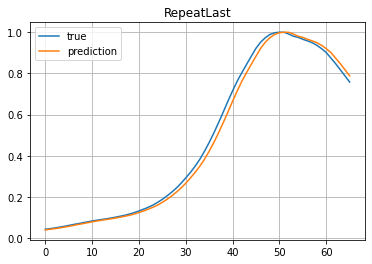

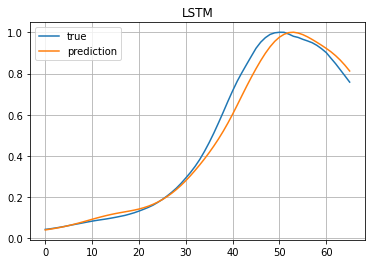

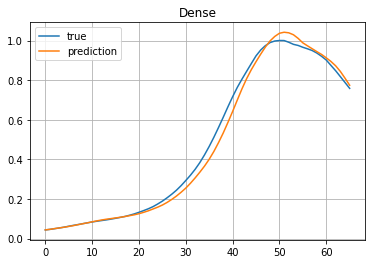

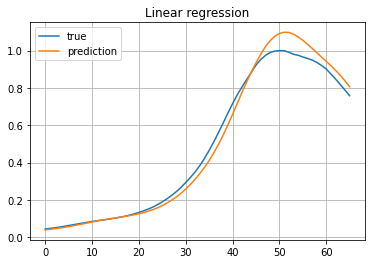

,MSE,MAE
Model,,
RepeatLast,0.000569,0.018199
Dense,0.001080,0.023430
Linear regression,0.002087,0.034039
LSTM,0.002135,0.031109


In [36]:
error_set(all_models, valid_datapoints)

## Test

BE


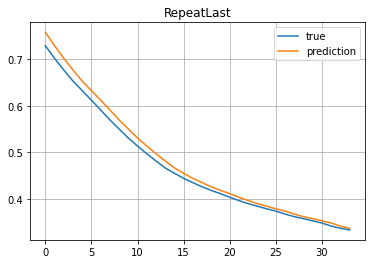

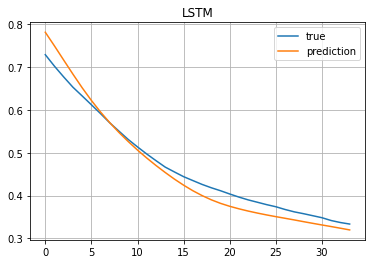

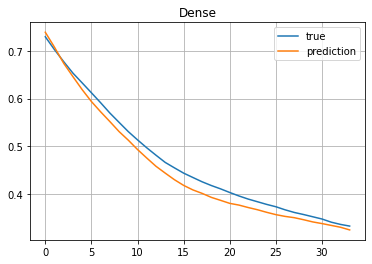

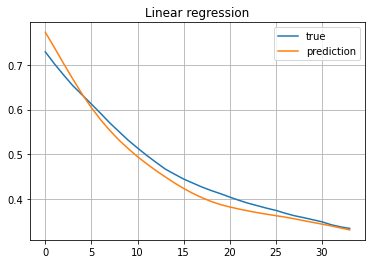

,MSE,MAE
Model,,
RepeatLast,0.000214,0.012494
Dense,0.000309,0.016299
Linear regression,0.000350,0.016241
LSTM,0.000539,0.020128


In [37]:
error_set(all_models, test_datapoints)